In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
#import pytorch for building RNN model
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
#import scaler for normalization
from sklearn.preprocessing import MinMaxScaler

In [2]:
#define a function to split data into train and test sets
def split_data(stock, lookback):
    data_raw = stock # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback+1])
    data = np.array(data);
    
    #split into test and train
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]



In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, n_layers, drop_prob=0.2):
        super(RNN, self).__init__()
        
        #Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        #Defining layers
        #RNN, use dropout to avoid overfitting
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        #Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        #activation function, using RELU to prevent shrinking the gradient
        self.relu = nn.ReLU()
    
    def forward(self, x, h):
        out, h = self.rnn(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self,batch_size):
        #generates the first hidden state of zeros used in the forward pass
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        return hidden
    
def train(train_loader, test_loader, learn_rate, hidden_dim=64, EPOCHS=20, model_type="RNN", loss_func="mse"):
    # Setting common hyperparameters
    input_dim = 1
    output_dim = 1
    n_layers = 1
    
    # Instantiating the models
    model = RNN(input_dim, hidden_dim, output_dim, n_layers)
    
    # Defining loss function and optimizer
    train_loss = []
    test_loss = []
    if (loss_func == "l1"):
        criterion = nn.L1Loss()
    else:
        criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.perf_counter()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        for x, label in train_loader:
            h = h.data
            model.zero_grad()
            
            out, h = model.forward(x.float(), h)
            loss = criterion(out, label.float())
            loss.backward()
            
            optimizer.step()
            avg_loss += loss.item()
    
        length = len(train_loader)
        avg_loss /= length
        train_loss.append(avg_loss)
        print("Epoch {}/{} Done, Total Training Loss: {}".format(epoch, EPOCHS, avg_loss))
        
        predictions = []
        values = []
        
        h = model.init_hidden(1)
        
        #define loss function criterion
        if(loss_func == "l1"):
            criterion = nn.L1Loss()
        else:
            #default
            criterion = nn.MSELoss()
        
        for x, label in test_loader:
            length = len(test_loader)
            avg_loss2 = 0.
            h = h.data
            model.zero_grad()
            
            out, h = model.forward(x.float(), h)
            loss2 = criterion(out, label.float()).item()
            avg_loss2 += loss2
            
            
            predictions.append(out.detach().numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))
            
        test_loss.append(avg_loss2)
        print("Total Testing MSELoss: {}".format(avg_loss2))
        
        current_time = time.perf_counter()
        epoch_times.append(current_time-start_time)
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        print()
    
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model, train_loss, test_loss, predictions, values

def evaluate(model, test_loader, loss_func="mse"):
    with torch.no_grad():
        predictions = []
        values = []
        test_loss = []
        h = model.init_hidden(1)
        if(loss_func == "l1"):
            criterion = nn.L1Loss()
        else:
            criterion = nn.MSELoss()
        for x, label in test_loader:
            h = h.data
            model.zero_grad()
            #print(x.float().shape,h.shape)
            #print(x.float(),h)
            out, h = model.forward(x.float(), h)
            loss = criterion(out, label.float())
            loss = loss.item()
            loss_arr.append(loss)
            predictions.append(out.numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))

    return predictions, values, loss, loss_arr

In [4]:
#data source path
dataset_folder = "../../dataset/"

# Microsoft

In [5]:
#load data
microsoft_df = pd.read_csv(dataset_folder + "microsoft.csv")

In [6]:
#use the close prices for analysis
microsoft_df['Date'] = pd.to_datetime(microsoft_df['Date'])
microsoft_df.set_index('Date',inplace=True)
microsoft_df.drop(columns=['Open','High','Low','Volume'],inplace=True)
microsoft_df

,Close
Date,
2015-04-01 16:00:00,40.72
2015-04-02 16:00:00,40.29
2015-04-06 16:00:00,41.55
2015-04-07 16:00:00,41.53
2015-04-08 16:00:00,41.42
...,...
2021-03-25 16:00:00,232.34
2021-03-26 16:00:00,236.48
2021-03-29 16:00:00,235.24


In [7]:
#normalize the data to the range 0-1
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(microsoft_df.values.reshape(-1,1))
scaled

array([[0.00210064],
       [0.        ],
       [0.00615535],
       ...,
       [0.95236932],
       [0.9358085 ],
       [0.95495848]])

In [8]:
#split the data
lookback = 5 # choose sequence length
train_x,train_y,test_x,test_y = split_data(scaled, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1205, 5, 1)
y_train.shape:  (1205, 1)
X_test.shape:  (301, 5, 1)
y_test.shape:  (301, 1)


In [9]:
#prepare the data to make it suitable for putting into the model
#organize data into batches to make the backpropogation easier
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [10]:
lr = 0.001
rnn_micro, micro_train_mse, micro_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func="mse")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.0031242595157252523


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Total Testing MSELoss: 0.12635120749473572
Total Time Elapsed: 0.22545835699999994 seconds

Epoch 2/20 Done, Total Training Loss: 0.05285407389955425
Total Testing MSELoss: 0.34942010045051575
Total Time Elapsed: 0.17572432399999993 seconds

Epoch 3/20 Done, Total Training Loss: 0.023844650573713856
Total Testing MSELoss: 0.21184900403022766
Total Time Elapsed: 0.16644791999999953 seconds

Epoch 4/20 Done, Total Training Loss: 0.0241009901437792
Total Testing MSELoss: 0.18547718226909637
Total Time Elapsed: 0.1616230009999997 seconds

Epoch 5/20 Done, Total Training Loss: 0.024139777581277066
Total Testing MSELoss: 0.1908465325832367
Total Time Elapsed: 0.15711486199999936 seconds

Epoch 6/20 Done, Total Training Loss: 0.016441678058047703
Total Testing MSELoss: 0.12460553646087646
Total Time Elapsed: 0.1919358339999997 seconds

Epoch 7/20 Done, Total Training Loss: 0.010991852852434071
Total Testing MSELoss: 0.05511745810508728
Total Time Elapsed: 0.1643074819999999 seconds

Epoch 8/2

In [11]:
loss_df = pd.DataFrame(micro_train_mse, columns = ["micro_train_mse"])
loss_df['micro_test_mse'] = micro_test_mse
loss_df

,micro_train_mse,micro_test_mse
0,0.003124,0.126351
1,0.052854,0.349420
2,0.023845,0.211849
3,0.024101,0.185477
4,0.024140,0.190847
5,0.016442,0.124606
6,0.010992,0.055117
7,0.005984,0.013843
8,0.000733,0.013145
9,0.000339,0.008555


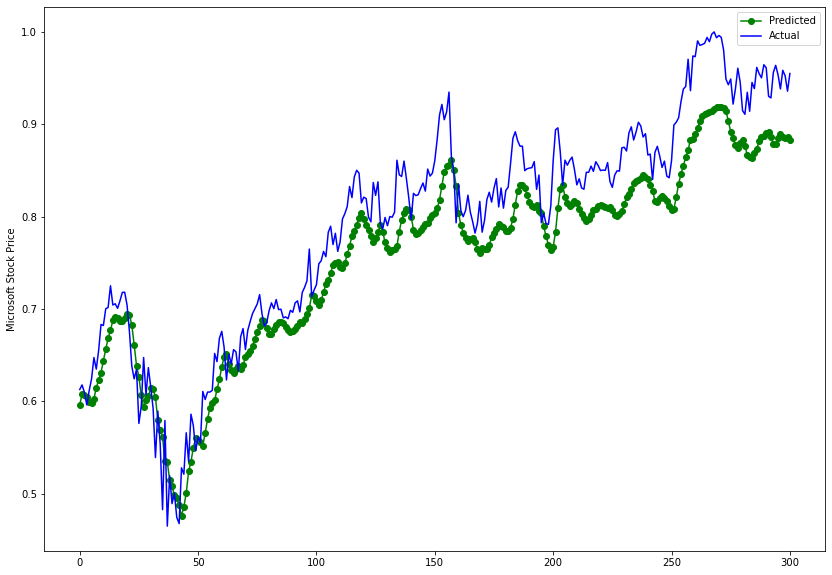

In [12]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Microsoft Stock Price')
plt.legend()

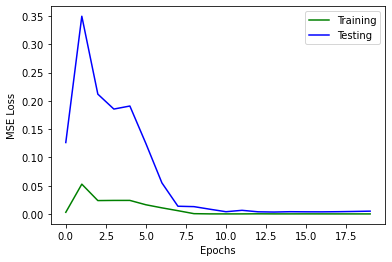

In [13]:
plt.plot(micro_train_mse, color="g", label="Training")
plt.plot(micro_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [14]:
lr = 0.001
rnn_micro2, micro_train_l1, micro_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func="l1")

/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.04071305164865948
Total Testing MSELoss: 0.3690328001976013
Total Time Elapsed: 0.17368138799999855 seconds

Epoch 2/20 Done, Total Training Loss: 0.26401995550337676
Total Testing MSELoss: 0.6947241425514221
Total Time Elapsed: 0.17210209400000132 seconds

Epoch 3/20 Done, Total Training Loss: 0.07826877803214498
Total Testing MSELoss: 0.3086414337158203
Total Time Elapsed: 0.2505337240000003 seconds

Epoch 4/20 Done, Total Training Loss: 0.16581970380266775
Total Testing MSELoss: 0.34569960832595825
Total Time Elapsed: 0.23529217499999966 seconds

Epoch 5/20 Done, Total Training Loss: 0.18229243517979174
Total Testing MSELoss: 0.4596998691558838
Total Time Elapsed: 0.1909428350000013 seconds

Epoch 6/20 Done, Total Training Loss: 0.1447563343429686
Total Testing MSELoss: 0.4140705466270447
Total Time Elapsed: 0.16748238099999924 seconds

Epoch 7/20 Done, Total Training Loss: 0.13495653979731975
Total Testing MSELo

In [15]:
loss_df['micro_train_l1'] = micro_train_l1
loss_df['micro_test_l1'] = micro_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1
0,0.003124,0.126351,0.040713,0.369033
1,0.052854,0.349420,0.264020,0.694724
2,0.023845,0.211849,0.078269,0.308641
3,0.024101,0.185477,0.165820,0.345700
4,0.024140,0.190847,0.182292,0.459700
5,0.016442,0.124606,0.144756,0.414071
6,0.010992,0.055117,0.134957,0.386704
7,0.005984,0.013843,0.109368,0.250617
8,0.000733,0.013145,0.109945,0.202684
9,0.000339,0.008555,0.075010,0.162090


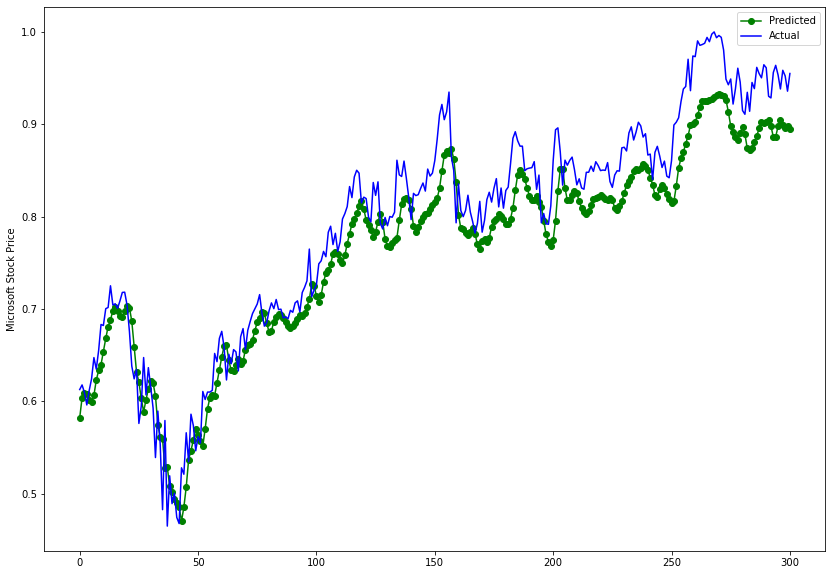

In [16]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Microsoft Stock Price')
plt.legend()

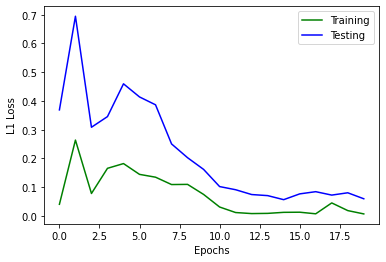

In [17]:
plt.plot(micro_train_l1, color="g", label="Training")
plt.plot(micro_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Artificial Data

In [18]:
art_data = pd.read_csv(dataset_folder +"Artificial_trend.csv")
art_data.set_index('date',inplace=True)
len(art_data)

7307

In [19]:
#normalize the data to the range 0-1
scaler = MinMaxScaler()
scaled_art1 = scaler.fit_transform(art_data.values.reshape(-1,1))
scaled_art1

array([[0.44861011],
       [0.44234504],
       [0.41956507],
       ...,
       [0.38776852],
       [0.4008299 ],
       [0.41748377]])

In [20]:
lookback = 5 # choose sequence length
train_x,train_y,test_x,test_y = split_data(scaled_art1, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (5842, 5, 1)
y_train.shape:  (5842, 1)
X_test.shape:  (1460, 5, 1)
y_test.shape:  (1460, 1)


In [21]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [22]:
lr = 0.001
rnn_art1, art1_train_mse, art1_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.058537963241758334


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Total Testing MSELoss: 0.009267188608646393
Total Time Elapsed: 0.7079578949999998 seconds

Epoch 2/20 Done, Total Training Loss: 0.03316092935830846
Total Testing MSELoss: 0.0021868536714464426
Total Time Elapsed: 0.6878840329999996 seconds

Epoch 3/20 Done, Total Training Loss: 0.025474046780740597
Total Testing MSELoss: 0.003804972628131509
Total Time Elapsed: 0.6985295100000002 seconds

Epoch 4/20 Done, Total Training Loss: 0.018344801864049468
Total Testing MSELoss: 0.004885406699031591
Total Time Elapsed: 0.673437667 seconds

Epoch 5/20 Done, Total Training Loss: 0.01083249588731093
Total Testing MSELoss: 0.008263401687145233
Total Time Elapsed: 0.7022430069999999 seconds

Epoch 6/20 Done, Total Training Loss: 0.0052736457155833204
Total Testing MSELoss: 0.00010807627404574305
Total Time Elapsed: 0.6741716370000006 seconds

Epoch 7/20 Done, Total Training Loss: 0.0022127900437636117
Total Testing MSELoss: 3.448384859439102e-06
Total Time Elapsed: 0.6919329579999989 seconds

Epoch

In [23]:
loss_df['art1_train_mse'] = art1_train_mse
loss_df['art1_test_mse'] = art1_test_mse
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse
0,0.003124,0.126351,0.040713,0.369033,0.058538,0.009267
1,0.052854,0.349420,0.264020,0.694724,0.033161,0.002187
2,0.023845,0.211849,0.078269,0.308641,0.025474,0.003805
3,0.024101,0.185477,0.165820,0.345700,0.018345,0.004885
4,0.024140,0.190847,0.182292,0.459700,0.010832,0.008263
5,0.016442,0.124606,0.144756,0.414071,0.005274,0.000108
6,0.010992,0.055117,0.134957,0.386704,0.002213,0.000003
7,0.005984,0.013843,0.109368,0.250617,0.001438,0.000055
8,0.000733,0.013145,0.109945,0.202684,0.000908,0.000204
9,0.000339,0.008555,0.075010,0.162090,0.000595,0.000369


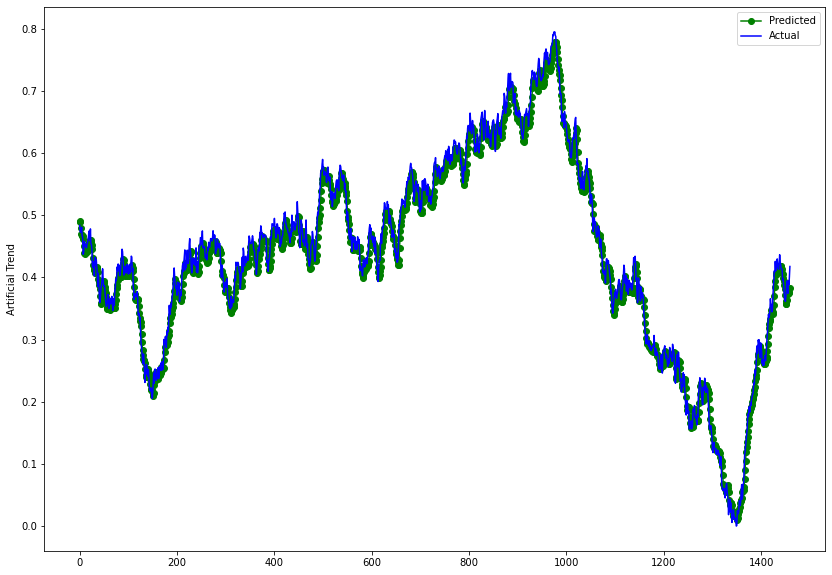

In [24]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artificial Trend')
plt.legend()

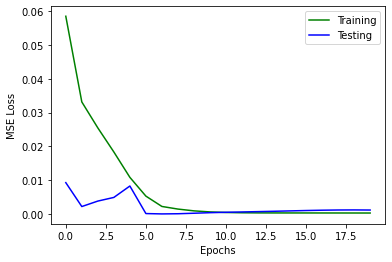

In [25]:
plt.plot(art1_train_mse, color="g", label="Training")
plt.plot(art1_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [26]:
lr = 0.001
rnn_art1_l1, art1_train_l1, art1_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func="l1")

/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.20903382609997476
Total Testing MSELoss: 0.13008692860603333
Total Time Elapsed: 0.7277459710000009 seconds

Epoch 2/20 Done, Total Training Loss: 0.16514654981566
Total Testing MSELoss: 0.0860125720500946
Total Time Elapsed: 0.7262588189999981 seconds

Epoch 3/20 Done, Total Training Loss: 0.13522427334644638
Total Testing MSELoss: 0.13642534613609314
Total Time Elapsed: 0.6995841649999974 seconds

Epoch 4/20 Done, Total Training Loss: 0.12846630586536376
Total Testing MSELoss: 0.0872216522693634
Total Time Elapsed: 0.7065132299999988 seconds

Epoch 5/20 Done, Total Training Loss: 0.10841623845172453
Total Testing MSELoss: 0.10116294026374817
Total Time Elapsed: 0.6967938950000025 seconds

Epoch 6/20 Done, Total Training Loss: 0.1037988766086298
Total Testing MSELoss: 0.11322817206382751
Total Time Elapsed: 0.6949851660000022 seconds

Epoch 7/20 Done, Total Training Loss: 0.0776754213640323
Total Testing MSELoss: 0

In [27]:
loss_df['art1_train_l1'] = art1_train_l1
loss_df['art1_test_l1'] = art1_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1
0,0.003124,0.126351,0.040713,0.369033,0.058538,0.009267,0.209034,0.130087
1,0.052854,0.349420,0.264020,0.694724,0.033161,0.002187,0.165147,0.086013
2,0.023845,0.211849,0.078269,0.308641,0.025474,0.003805,0.135224,0.136425
3,0.024101,0.185477,0.165820,0.345700,0.018345,0.004885,0.128466,0.087222
4,0.024140,0.190847,0.182292,0.459700,0.010832,0.008263,0.108416,0.101163
5,0.016442,0.124606,0.144756,0.414071,0.005274,0.000108,0.103799,0.113228
6,0.010992,0.055117,0.134957,0.386704,0.002213,0.000003,0.077675,0.055124
7,0.005984,0.013843,0.109368,0.250617,0.001438,0.000055,0.050978,0.049326
8,0.000733,0.013145,0.109945,0.202684,0.000908,0.000204,0.037049,0.038030
9,0.000339,0.008555,0.075010,0.162090,0.000595,0.000369,0.027755,0.038949


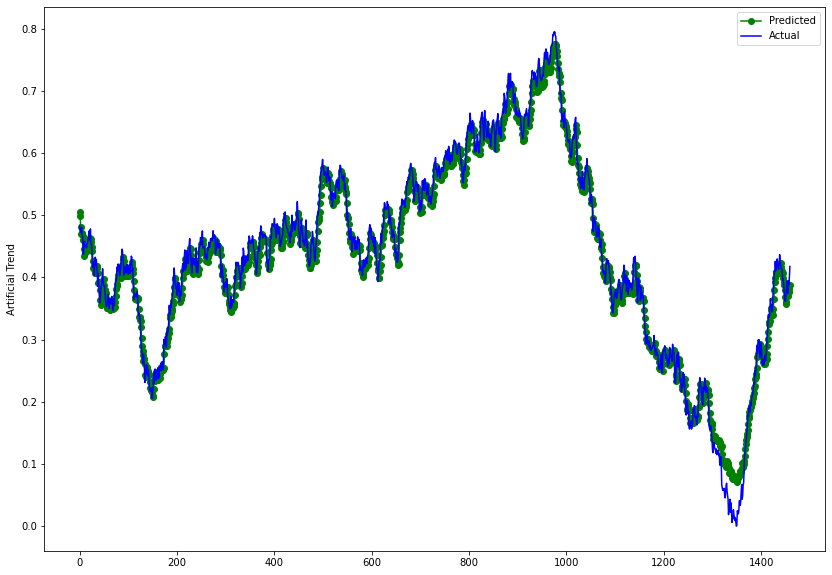

In [28]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artificial Trend')
plt.legend()

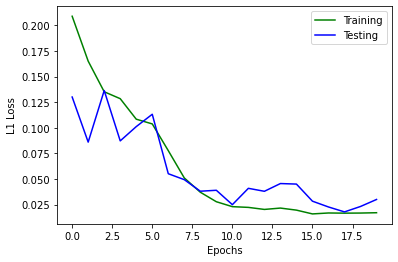

In [29]:
plt.plot(art1_train_l1, color="g", label="Training")
plt.plot(art1_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Crude Oil

In [30]:
oil_data = pd.read_csv(dataset_folder +"oil.csv")
oil_data['DATE'] = pd.to_datetime(oil_data['DATE'])
oil_data.set_index('DATE',inplace=True)
len(oil_data)

1566

In [31]:
oil_data[oil_data['DCOILBRENTEU'] == "."] = np.NaN
oil_data.dropna(inplace=True)
oil_data['DCOILBRENTEU'] = oil_data['DCOILBRENTEU'].astype("float")
oil_data

,DCOILBRENTEU
DATE,
2015-11-02,47.91
2015-11-03,48.00
2015-11-04,46.96
2015-11-05,47.19
2015-11-06,46.09
...,...
2021-10-26,85.11
2021-10-27,84.12
2021-10-28,83.40


In [32]:
#scaling the oil data
scaler = MinMaxScaler()
scaled_oil = scaler.fit_transform(oil_data.values)

train_x,train_y,test_x,test_y = split_data(scaled_oil, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1219, 5, 1)
y_train.shape:  (1219, 1)
X_test.shape:  (305, 5, 1)
y_test.shape:  (305, 1)


In [33]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [34]:
lr = 0.001
rnn_oil, oil_train_mse, oil_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.0534097169898144
Total Testing MSELoss: 0.29360777139663696
Total Time Elapsed: 0.17798514199999715 seconds



/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 2/20 Done, Total Training Loss: 0.03752436016465684
Total Testing MSELoss: 0.1370343416929245
Total Time Elapsed: 0.16983660899999364 seconds

Epoch 3/20 Done, Total Training Loss: 0.046503376388787536
Total Testing MSELoss: 0.15434880554676056
Total Time Elapsed: 0.1715687860000017 seconds

Epoch 4/20 Done, Total Training Loss: 0.040056876384800204
Total Testing MSELoss: 0.10713579505681992
Total Time Elapsed: 0.15844072600000203 seconds

Epoch 5/20 Done, Total Training Loss: 0.047790442970213724
Total Testing MSELoss: 0.05634491890668869
Total Time Elapsed: 0.1666796270000006 seconds

Epoch 6/20 Done, Total Training Loss: 0.043955576220469084
Total Testing MSELoss: 0.06829259544610977
Total Time Elapsed: 0.17132713799999522 seconds

Epoch 7/20 Done, Total Training Loss: 0.03703101999340824
Total Testing MSELoss: 0.05990204960107803
Total Time Elapsed: 0.1665923029999945 seconds

Epoch 8/20 Done, Total Training Loss: 0.03518527698830248
Total Testing MSELoss: 0.03585272654891014

In [35]:
loss_df['oil_train_mse'] = oil_train_mse
loss_df['oil_test_mse'] = oil_test_mse
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse
0,0.003124,0.126351,0.040713,0.369033,0.058538,0.009267,0.209034,0.130087,0.053410,0.293608
1,0.052854,0.349420,0.264020,0.694724,0.033161,0.002187,0.165147,0.086013,0.037524,0.137034
2,0.023845,0.211849,0.078269,0.308641,0.025474,0.003805,0.135224,0.136425,0.046503,0.154349
3,0.024101,0.185477,0.165820,0.345700,0.018345,0.004885,0.128466,0.087222,0.040057,0.107136
4,0.024140,0.190847,0.182292,0.459700,0.010832,0.008263,0.108416,0.101163,0.047790,0.056345
5,0.016442,0.124606,0.144756,0.414071,0.005274,0.000108,0.103799,0.113228,0.043956,0.068293
6,0.010992,0.055117,0.134957,0.386704,0.002213,0.000003,0.077675,0.055124,0.037031,0.059902
7,0.005984,0.013843,0.109368,0.250617,0.001438,0.000055,0.050978,0.049326,0.035185,0.035853
8,0.000733,0.013145,0.109945,0.202684,0.000908,0.000204,0.037049,0.038030,0.034035,0.039759
9,0.000339,0.008555,0.075010,0.162090,0.000595,0.000369,0.027755,0.038949,0.028856,0.039875


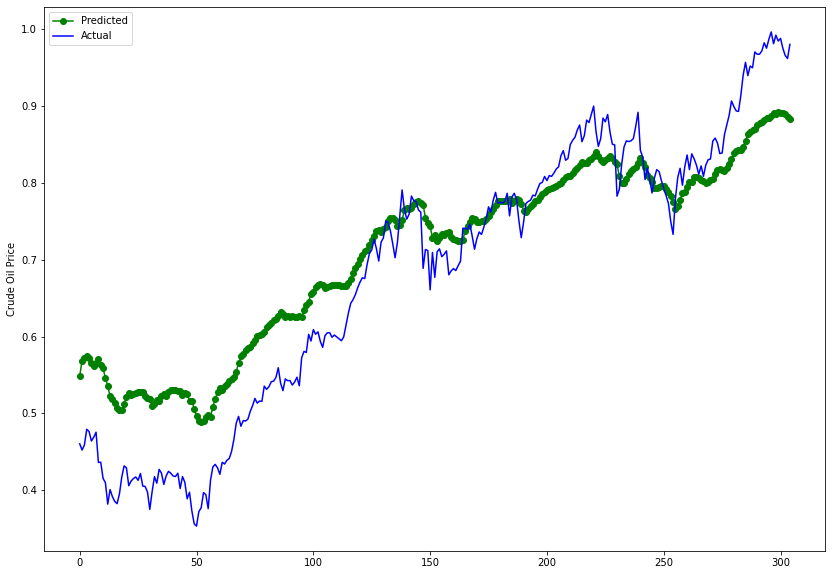

In [36]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Crude Oil Price')
plt.legend()

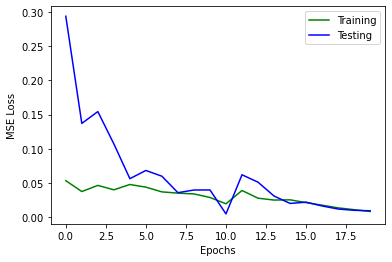

In [37]:
plt.plot(oil_train_mse, color="g", label="Training")
plt.plot(oil_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [38]:
lr = 0.001
rnn_oil2, oil_train_l1, oil_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func="l1")

/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.2715376228290169
Total Testing MSELoss: 0.4417644143104553
Total Time Elapsed: 0.1950881599999974 seconds

Epoch 2/20 Done, Total Training Loss: 0.1882171570078323
Total Testing MSELoss: 0.263261079788208
Total Time Elapsed: 0.17849154499999997 seconds

Epoch 3/20 Done, Total Training Loss: 0.18791114254609534
Total Testing MSELoss: 0.24905961751937866
Total Time Elapsed: 0.17038221899999684 seconds

Epoch 4/20 Done, Total Training Loss: 0.1842765930157743
Total Testing MSELoss: 0.2351011037826538
Total Time Elapsed: 0.16268084300000396 seconds

Epoch 5/20 Done, Total Training Loss: 0.17968079947719448
Total Testing MSELoss: 0.21927869319915771
Total Time Elapsed: 0.1689154319999986 seconds

Epoch 6/20 Done, Total Training Loss: 0.18821927807048747
Total Testing MSELoss: 0.23432326316833496
Total Time Elapsed: 0.17269819799999908 seconds

Epoch 7/20 Done, Total Training Loss: 0.2000189868635253
Total Testing MSELoss

In [39]:
loss_df['oil_train_l1'] = oil_train_l1
loss_df['oil_test_l1'] = oil_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1
0,0.003124,0.126351,0.040713,0.369033,0.058538,0.009267,0.209034,0.130087,0.053410,0.293608,0.271538,0.441764
1,0.052854,0.349420,0.264020,0.694724,0.033161,0.002187,0.165147,0.086013,0.037524,0.137034,0.188217,0.263261
2,0.023845,0.211849,0.078269,0.308641,0.025474,0.003805,0.135224,0.136425,0.046503,0.154349,0.187911,0.249060
3,0.024101,0.185477,0.165820,0.345700,0.018345,0.004885,0.128466,0.087222,0.040057,0.107136,0.184277,0.235101
4,0.024140,0.190847,0.182292,0.459700,0.010832,0.008263,0.108416,0.101163,0.047790,0.056345,0.179681,0.219279
5,0.016442,0.124606,0.144756,0.414071,0.005274,0.000108,0.103799,0.113228,0.043956,0.068293,0.188219,0.234323
6,0.010992,0.055117,0.134957,0.386704,0.002213,0.000003,0.077675,0.055124,0.037031,0.059902,0.200019,0.240416
7,0.005984,0.013843,0.109368,0.250617,0.001438,0.000055,0.050978,0.049326,0.035185,0.035853,0.181617,0.318170
8,0.000733,0.013145,0.109945,0.202684,0.000908,0.000204,0.037049,0.038030,0.034035,0.039759,0.158585,0.252316
9,0.000339,0.008555,0.075010,0.162090,0.000595,0.000369,0.027755,0.038949,0.028856,0.039875,0.183312,0.228947


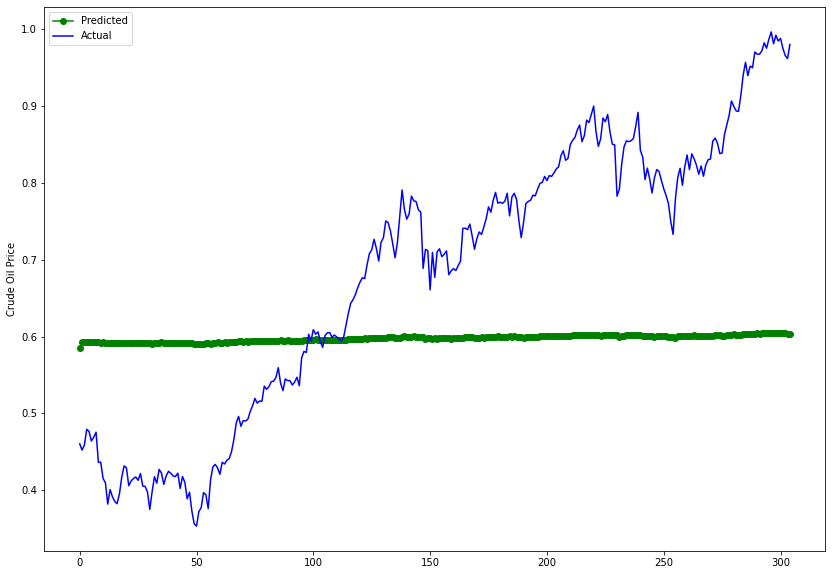

In [40]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Crude Oil Price')
plt.legend()

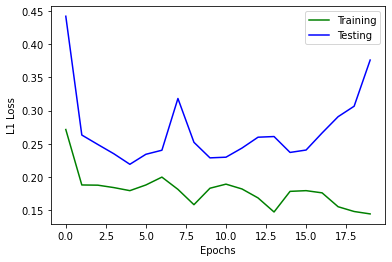

In [41]:
plt.plot(oil_train_l1, color="g", label="Training")
plt.plot(oil_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Bitcoin

In [42]:
coin_df = pd.read_csv(dataset_folder + "coin.csv")
coin_df['Date'] = pd.to_datetime(coin_df['Date'])
coin_df.set_index('Date', inplace=True)
coin_df = pd.DataFrame(coin_df['Close'])
coin_df.dropna(inplace=True)
coin_df

,Close
Date,
2013-04-29 23:59:59,144.539993
2013-04-30 23:59:59,139.000000
2013-05-01 23:59:59,116.989998
2013-05-02 23:59:59,105.209999
2013-05-03 23:59:59,97.750000
...,...
2021-07-02 23:59:59,33897.048590
2021-07-03 23:59:59,34668.548402
2021-07-04 23:59:59,35287.779766


In [43]:
#scaling the coin data
scaler = MinMaxScaler()
scaled_coin = scaler.fit_transform(coin_df.values)

train_x,train_y,test_x,test_y = split_data(scaled_coin, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (2389, 5, 1)
y_train.shape:  (2389, 1)
X_test.shape:  (597, 5, 1)
y_test.shape:  (597, 1)


In [44]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [45]:
lr = 0.001
rnn_coin, coin_train_mse, coin_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.0018658820420360163


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Total Testing MSELoss: 0.17614151537418365
Total Time Elapsed: 0.3773112219999959 seconds

Epoch 2/20 Done, Total Training Loss: 0.003268303520298031
Total Testing MSELoss: 0.15649810433387756
Total Time Elapsed: 0.29055617699999914 seconds

Epoch 3/20 Done, Total Training Loss: 0.0037510156507778447
Total Testing MSELoss: 0.1540970653295517
Total Time Elapsed: 0.29273797900000176 seconds

Epoch 4/20 Done, Total Training Loss: 0.004650892564578081
Total Testing MSELoss: 0.1507604569196701
Total Time Elapsed: 0.2958716790000011 seconds

Epoch 5/20 Done, Total Training Loss: 0.005671638371139223
Total Testing MSELoss: 0.20124034583568573
Total Time Elapsed: 0.289897780000004 seconds

Epoch 6/20 Done, Total Training Loss: 0.004514142070695163
Total Testing MSELoss: 0.1866932511329651
Total Time Elapsed: 0.28184411099999807 seconds

Epoch 7/20 Done, Total Training Loss: 0.004543776969807663
Total Testing MSELoss: 0.2035972625017166
Total Time Elapsed: 0.2909391960000036 seconds

Epoch 8/20

In [46]:
loss_df['coin_train_mse'] = coin_train_mse
loss_df['coin_test_mse'] = coin_test_mse
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1,coin_train_mse,coin_test_mse
0,0.003124,0.126351,0.040713,0.369033,0.058538,0.009267,0.209034,0.130087,0.053410,0.293608,0.271538,0.441764,0.001866,0.176142
1,0.052854,0.349420,0.264020,0.694724,0.033161,0.002187,0.165147,0.086013,0.037524,0.137034,0.188217,0.263261,0.003268,0.156498
2,0.023845,0.211849,0.078269,0.308641,0.025474,0.003805,0.135224,0.136425,0.046503,0.154349,0.187911,0.249060,0.003751,0.154097
3,0.024101,0.185477,0.165820,0.345700,0.018345,0.004885,0.128466,0.087222,0.040057,0.107136,0.184277,0.235101,0.004651,0.150760
4,0.024140,0.190847,0.182292,0.459700,0.010832,0.008263,0.108416,0.101163,0.047790,0.056345,0.179681,0.219279,0.005672,0.201240
5,0.016442,0.124606,0.144756,0.414071,0.005274,0.000108,0.103799,0.113228,0.043956,0.068293,0.188219,0.234323,0.004514,0.186693
6,0.010992,0.055117,0.134957,0.386704,0.002213,0.000003,0.077675,0.055124,0.037031,0.059902,0.200019,0.240416,0.004544,0.203597
7,0.005984,0.013843,0.109368,0.250617,0.001438,0.000055,0.050978,0.049326,0.035185,0.035853,0.181617,0.318170,0.003598,0.179354
8,0.000733,0.013145,0.109945,0.202684,0.000908,0.000204,0.037049,0.038030,0.034035,0.039759,0.158585,0.252316,0.004027,0.171502
9,0.000339,0.008555,0.075010,0.162090,0.000595,0.000369,0.027755,0.038949,0.028856,0.039875,0.183312,0.228947,0.003339,0.160914


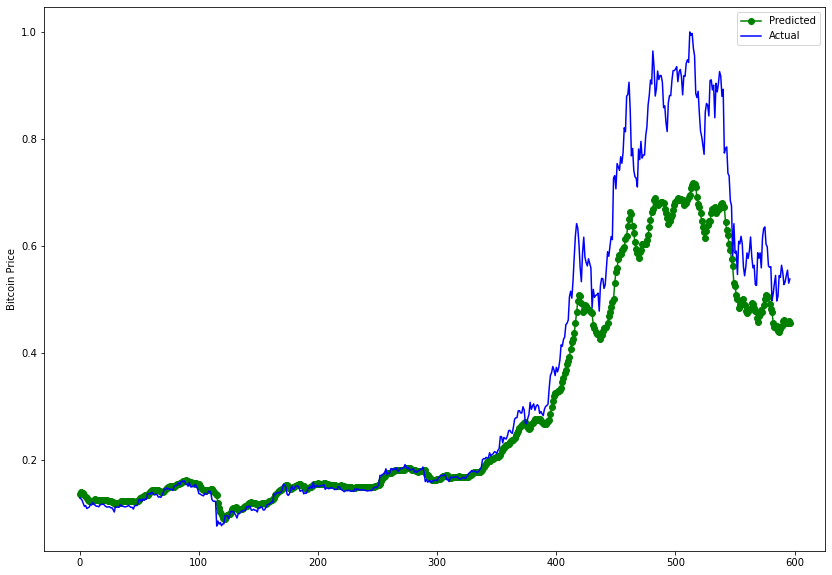

In [47]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Bitcoin Price')
plt.legend()

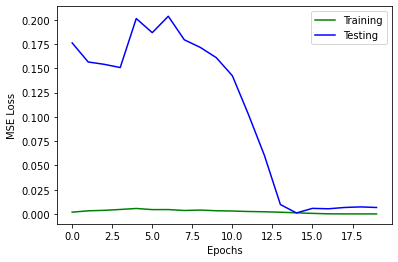

In [48]:
plt.plot(coin_train_mse, color="g", label="Training")
plt.plot(coin_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [49]:
lr = 0.001
rnn_coin2, coin_train_l1, coin_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func = "l1")

/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.028613654608724993
Total Testing MSELoss: 0.39841026067733765
Total Time Elapsed: 0.3108854259999987 seconds

Epoch 2/20 Done, Total Training Loss: 0.060015744743617
Total Testing MSELoss: 0.419327974319458
Total Time Elapsed: 0.26895687799999735 seconds

Epoch 3/20 Done, Total Training Loss: 0.05341779117824862
Total Testing MSELoss: 0.4000534415245056
Total Time Elapsed: 0.2969835310000022 seconds

Epoch 4/20 Done, Total Training Loss: 0.04955481121165527
Total Testing MSELoss: 0.3856896758079529
Total Time Elapsed: 0.28104506300000054 seconds

Epoch 5/20 Done, Total Training Loss: 0.05057877259379303
Total Testing MSELoss: 0.38008952140808105
Total Time Elapsed: 0.2879257889999991 seconds

Epoch 6/20 Done, Total Training Loss: 0.06366152374224888
Total Testing MSELoss: 0.3967728912830353
Total Time Elapsed: 0.2929328869999992 seconds

Epoch 7/20 Done, Total Training Loss: 0.06208429859347037
Total Testing MSELoss

In [50]:
loss_df['coin_train_l1'] = coin_train_l1
loss_df['coin_test_l1'] = coin_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1,coin_train_mse,coin_test_mse,coin_train_l1,coin_test_l1
0,0.003124,0.126351,0.040713,0.369033,0.058538,0.009267,0.209034,0.130087,0.053410,0.293608,0.271538,0.441764,0.001866,0.176142,0.028614,0.398410
1,0.052854,0.349420,0.264020,0.694724,0.033161,0.002187,0.165147,0.086013,0.037524,0.137034,0.188217,0.263261,0.003268,0.156498,0.060016,0.419328
2,0.023845,0.211849,0.078269,0.308641,0.025474,0.003805,0.135224,0.136425,0.046503,0.154349,0.187911,0.249060,0.003751,0.154097,0.053418,0.400053
3,0.024101,0.185477,0.165820,0.345700,0.018345,0.004885,0.128466,0.087222,0.040057,0.107136,0.184277,0.235101,0.004651,0.150760,0.049555,0.385690
4,0.024140,0.190847,0.182292,0.459700,0.010832,0.008263,0.108416,0.101163,0.047790,0.056345,0.179681,0.219279,0.005672,0.201240,0.050579,0.380090
5,0.016442,0.124606,0.144756,0.414071,0.005274,0.000108,0.103799,0.113228,0.043956,0.068293,0.188219,0.234323,0.004514,0.186693,0.063662,0.396773
6,0.010992,0.055117,0.134957,0.386704,0.002213,0.000003,0.077675,0.055124,0.037031,0.059902,0.200019,0.240416,0.004544,0.203597,0.062084,0.388389
7,0.005984,0.013843,0.109368,0.250617,0.001438,0.000055,0.050978,0.049326,0.035185,0.035853,0.181617,0.318170,0.003598,0.179354,0.043945,0.357374
8,0.000733,0.013145,0.109945,0.202684,0.000908,0.000204,0.037049,0.038030,0.034035,0.039759,0.158585,0.252316,0.004027,0.171502,0.060772,0.369623
9,0.000339,0.008555,0.075010,0.162090,0.000595,0.000369,0.027755,0.038949,0.028856,0.039875,0.183312,0.228947,0.003339,0.160914,0.035518,0.277824


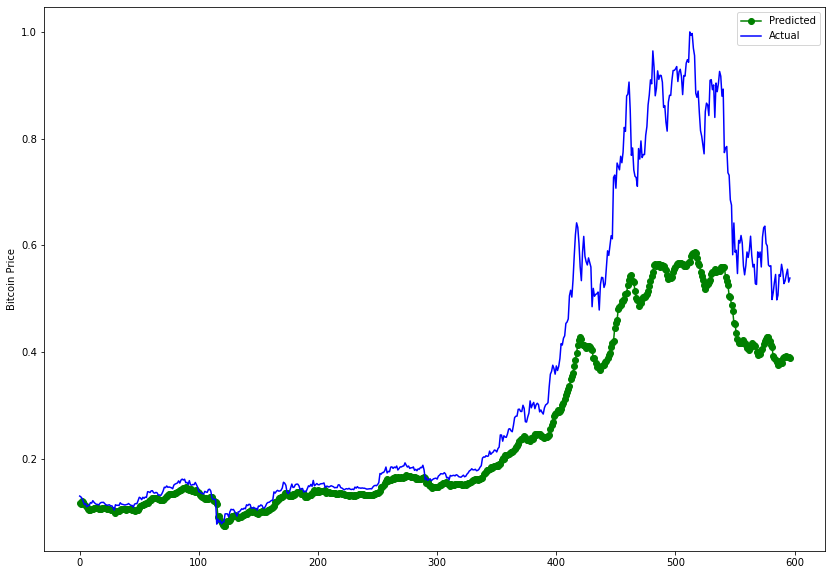

In [51]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Bitcoin Price')
plt.legend()

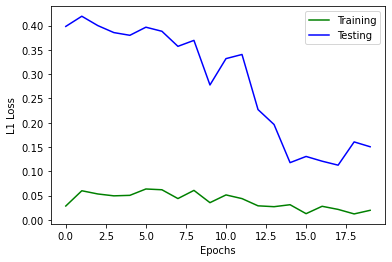

In [52]:
plt.plot(coin_train_l1, color="g", label="Training")
plt.plot(coin_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## S&P500

In [53]:
sp_df = pd.read_csv(dataset_folder + "sp500.csv")
sp_df['Date'] = pd.to_datetime(sp_df['Date'])
sp_df.set_index('Date', inplace=True)
sp_df = pd.DataFrame(sp_df['SP500'])
sp_df.dropna(inplace=True)
sp_df

,SP500
Date,
1871-01-01,4.44
1871-02-01,4.50
1871-03-01,4.61
1871-04-01,4.74
1871-05-01,4.86
...,...
2017-12-01,2664.34
2018-01-01,2789.80
2018-02-01,2705.16


In [54]:
#scaling the s&p data
scaler = MinMaxScaler()
scaled_sp = scaler.fit_transform(sp_df.values)

train_x,train_y,test_x,test_y = split_data(scaled_sp, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1410, 5, 1)
y_train.shape:  (1410, 1)
X_test.shape:  (353, 5, 1)
y_test.shape:  (353, 1)


In [55]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running the model with MSE loss

In [56]:
lr = 0.001
rnn_sp, sp_train_mse, sp_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.0006680078249785156


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Total Testing MSELoss: 0.7679662108421326
Total Time Elapsed: 0.1958175800000035 seconds

Epoch 2/20 Done, Total Training Loss: 0.0004997749186842784
Total Testing MSELoss: 0.6963328719139099
Total Time Elapsed: 0.1857902129999971 seconds

Epoch 3/20 Done, Total Training Loss: 0.0004640915663210101
Total Testing MSELoss: 0.7196527123451233
Total Time Elapsed: 0.192915665000001 seconds

Epoch 4/20 Done, Total Training Loss: 0.0005496532174114257
Total Testing MSELoss: 0.664326012134552
Total Time Elapsed: 0.184813106 seconds

Epoch 5/20 Done, Total Training Loss: 0.00045790734628587353
Total Testing MSELoss: 0.7057670950889587
Total Time Elapsed: 0.18705349600000432 seconds

Epoch 6/20 Done, Total Training Loss: 0.0005734138140269997
Total Testing MSELoss: 0.6999934911727905
Total Time Elapsed: 0.19823847000000683 seconds

Epoch 7/20 Done, Total Training Loss: 0.000477876893251244
Total Testing MSELoss: 0.6396927833557129
Total Time Elapsed: 0.18470584899999665 seconds

Epoch 8/20 Done,

In [57]:
loss_df['sp_train_mse'] = sp_train_mse
loss_df['sp_test_mse'] = sp_test_mse
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1,coin_train_mse,coin_test_mse,coin_train_l1,coin_test_l1,sp_train_mse,sp_test_mse
0,0.003124,0.126351,0.040713,0.369033,0.058538,0.009267,0.209034,0.130087,0.053410,0.293608,0.271538,0.441764,0.001866,0.176142,0.028614,0.398410,0.000668,0.767966
1,0.052854,0.349420,0.264020,0.694724,0.033161,0.002187,0.165147,0.086013,0.037524,0.137034,0.188217,0.263261,0.003268,0.156498,0.060016,0.419328,0.000500,0.696333
2,0.023845,0.211849,0.078269,0.308641,0.025474,0.003805,0.135224,0.136425,0.046503,0.154349,0.187911,0.249060,0.003751,0.154097,0.053418,0.400053,0.000464,0.719653
3,0.024101,0.185477,0.165820,0.345700,0.018345,0.004885,0.128466,0.087222,0.040057,0.107136,0.184277,0.235101,0.004651,0.150760,0.049555,0.385690,0.000550,0.664326
4,0.024140,0.190847,0.182292,0.459700,0.010832,0.008263,0.108416,0.101163,0.047790,0.056345,0.179681,0.219279,0.005672,0.201240,0.050579,0.380090,0.000458,0.705767
5,0.016442,0.124606,0.144756,0.414071,0.005274,0.000108,0.103799,0.113228,0.043956,0.068293,0.188219,0.234323,0.004514,0.186693,0.063662,0.396773,0.000573,0.699993
6,0.010992,0.055117,0.134957,0.386704,0.002213,0.000003,0.077675,0.055124,0.037031,0.059902,0.200019,0.240416,0.004544,0.203597,0.062084,0.388389,0.000478,0.639693
7,0.005984,0.013843,0.109368,0.250617,0.001438,0.000055,0.050978,0.049326,0.035185,0.035853,0.181617,0.318170,0.003598,0.179354,0.043945,0.357374,0.000467,0.708428
8,0.000733,0.013145,0.109945,0.202684,0.000908,0.000204,0.037049,0.038030,0.034035,0.039759,0.158585,0.252316,0.004027,0.171502,0.060772,0.369623,0.000422,0.684846
9,0.000339,0.008555,0.075010,0.162090,0.000595,0.000369,0.027755,0.038949,0.028856,0.039875,0.183312,0.228947,0.003339,0.160914,0.035518,0.277824,0.000455,0.662596


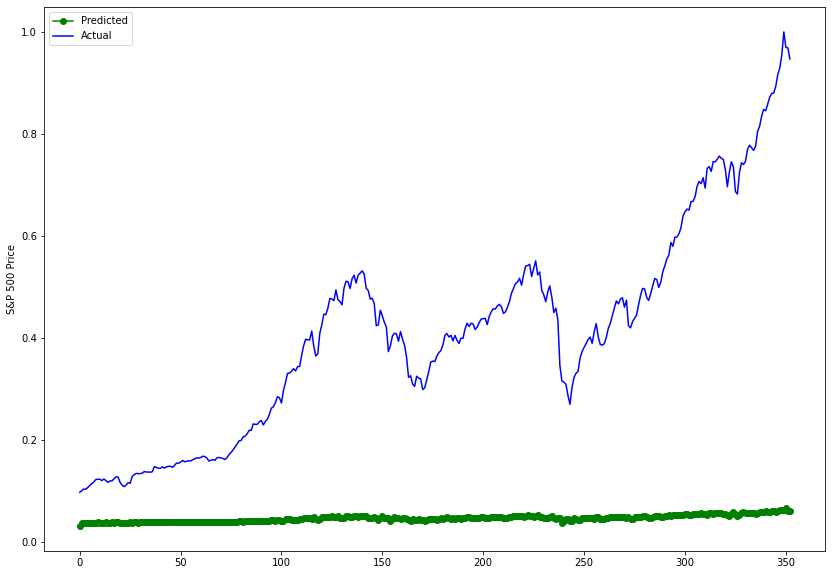

In [58]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('S&P 500 Price')
plt.legend()

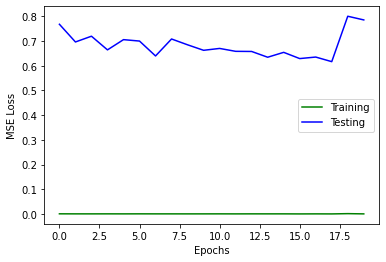

In [59]:
plt.plot(sp_train_mse, color="g", label="Training")
plt.plot(sp_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running the model with L1 loss

In [60]:
lr = 0.001
rnn_sp2, sp_train_l1, sp_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func = "l1")

/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.00858908009368778
Total Testing MSELoss: 0.8685191869735718
Total Time Elapsed: 0.18386282999999537 seconds

Epoch 2/20 Done, Total Training Loss: 0.01269699769380333
Total Testing MSELoss: 0.85930335521698
Total Time Elapsed: 0.19299811400000522 seconds

Epoch 3/20 Done, Total Training Loss: 0.011424007603305985
Total Testing MSELoss: 0.8287293910980225
Total Time Elapsed: 0.18718662999999935 seconds

Epoch 4/20 Done, Total Training Loss: 0.012630165607499128
Total Testing MSELoss: 0.8359638452529907
Total Time Elapsed: 0.17950362300000222 seconds

Epoch 5/20 Done, Total Training Loss: 0.014248193548899673
Total Testing MSELoss: 0.8240728974342346
Total Time Elapsed: 0.18802253500000177 seconds

Epoch 6/20 Done, Total Training Loss: 0.015667920524720103
Total Testing MSELoss: 0.7939226627349854
Total Time Elapsed: 0.19371851800001139 seconds

Epoch 7/20 Done, Total Training Loss: 0.024841330150428057
Total Testing 

In [61]:
loss_df['sp_train_l1'] = sp_train_l1
loss_df['sp_test_l1'] = sp_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,oil_train_l1,oil_test_l1,coin_train_mse,coin_test_mse,coin_train_l1,coin_test_l1,sp_train_mse,sp_test_mse,sp_train_l1,sp_test_l1
0,0.003124,0.126351,0.040713,0.369033,0.058538,0.009267,0.209034,0.130087,0.053410,0.293608,0.271538,0.441764,0.001866,0.176142,0.028614,0.398410,0.000668,0.767966,0.008589,0.868519
1,0.052854,0.349420,0.264020,0.694724,0.033161,0.002187,0.165147,0.086013,0.037524,0.137034,0.188217,0.263261,0.003268,0.156498,0.060016,0.419328,0.000500,0.696333,0.012697,0.859303
2,0.023845,0.211849,0.078269,0.308641,0.025474,0.003805,0.135224,0.136425,0.046503,0.154349,0.187911,0.249060,0.003751,0.154097,0.053418,0.400053,0.000464,0.719653,0.011424,0.828729
3,0.024101,0.185477,0.165820,0.345700,0.018345,0.004885,0.128466,0.087222,0.040057,0.107136,0.184277,0.235101,0.004651,0.150760,0.049555,0.385690,0.000550,0.664326,0.012630,0.835964
4,0.024140,0.190847,0.182292,0.459700,0.010832,0.008263,0.108416,0.101163,0.047790,0.056345,0.179681,0.219279,0.005672,0.201240,0.050579,0.380090,0.000458,0.705767,0.014248,0.824073
5,0.016442,0.124606,0.144756,0.414071,0.005274,0.000108,0.103799,0.113228,0.043956,0.068293,0.188219,0.234323,0.004514,0.186693,0.063662,0.396773,0.000573,0.699993,0.015668,0.793923
6,0.010992,0.055117,0.134957,0.386704,0.002213,0.000003,0.077675,0.055124,0.037031,0.059902,0.200019,0.240416,0.004544,0.203597,0.062084,0.388389,0.000478,0.639693,0.024841,0.822395
7,0.005984,0.013843,0.109368,0.250617,0.001438,0.000055,0.050978,0.049326,0.035185,0.035853,0.181617,0.318170,0.003598,0.179354,0.043945,0.357374,0.000467,0.708428,0.023162,0.819472
8,0.000733,0.013145,0.109945,0.202684,0.000908,0.000204,0.037049,0.038030,0.034035,0.039759,0.158585,0.252316,0.004027,0.171502,0.060772,0.369623,0.000422,0.684846,0.016713,0.815263
9,0.000339,0.008555,0.075010,0.162090,0.000595,0.000369,0.027755,0.038949,0.028856,0.039875,0.183312,0.228947,0.003339,0.160914,0.035518,0.277824,0.000455,0.662596,0.016627,0.827631


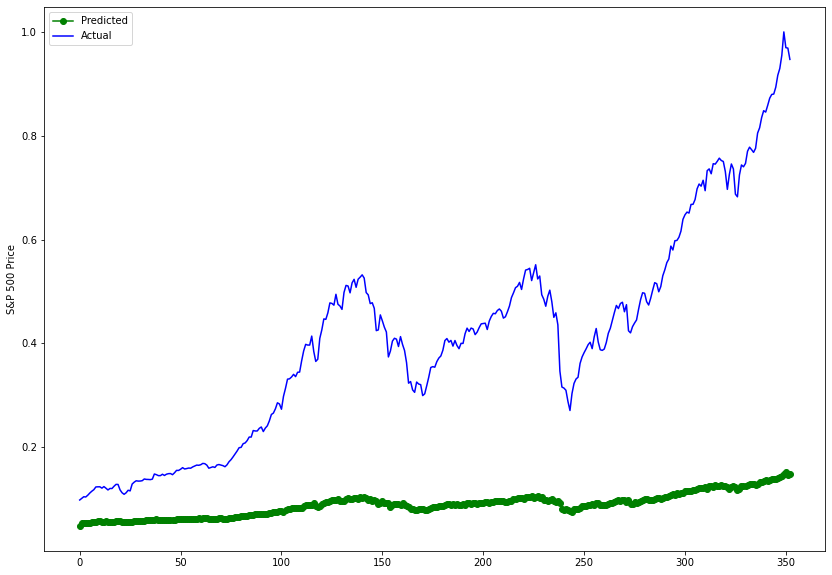

In [62]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('S&P 500 Price')
plt.legend()

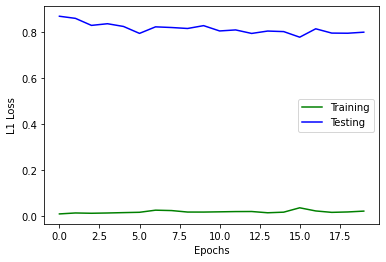

In [63]:
plt.plot(sp_train_l1, color="g", label="Training")
plt.plot(sp_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## Artificial Data 2

In [64]:
art2_df = pd.read_csv(dataset_folder + "Artificial_trend1.csv")
art2_df
art2_df['date'] = pd.to_datetime(art2_df['date'])
art2_df.set_index('date', inplace=True)
art2_df.dropna(inplace=True)
art2_df

,trend
date,
2000-07-01,-0.030415
2000-07-02,-0.025551
2000-07-03,-0.029866
2000-07-04,-0.034355
2000-07-05,-0.028927
...,...
2020-06-28,0.044721
2020-06-29,0.046374
2020-06-30,0.048462


In [65]:
#scaling the sencond artificial dataset
scaler = MinMaxScaler()
scaled_art2 = scaler.fit_transform(art2_df.values)

train_x,train_y,test_x,test_y = split_data(scaled_art2, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (5842, 5, 1)
y_train.shape:  (5842, 1)
X_test.shape:  (1460, 5, 1)
y_test.shape:  (1460, 1)


In [66]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

### (1) Running with MSE

In [67]:
lr = 0.001
rnn_art2, art2_train_mse, art2_test_mse, predictions, values = train(train_loader, test_loader, lr, model_type="RNN")

Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.039126042472032295


/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Total Testing MSELoss: 0.11541829258203506
Total Time Elapsed: 0.6614476489999959 seconds

Epoch 2/20 Done, Total Training Loss: 0.02596550035113878
Total Testing MSELoss: 0.12575463950634003
Total Time Elapsed: 0.7090964829999962 seconds

Epoch 3/20 Done, Total Training Loss: 0.01918896441322311
Total Testing MSELoss: 0.10164283215999603
Total Time Elapsed: 0.8679628240000028 seconds

Epoch 4/20 Done, Total Training Loss: 0.008793894916319975
Total Testing MSELoss: 0.034298524260520935
Total Time Elapsed: 0.6871641899999901 seconds

Epoch 5/20 Done, Total Training Loss: 0.0021336396719881714
Total Testing MSELoss: 0.002342697000131011
Total Time Elapsed: 0.7015910209999987 seconds

Epoch 6/20 Done, Total Training Loss: 0.001339311317469065
Total Testing MSELoss: 0.003580450313165784
Total Time Elapsed: 0.6834558139999984 seconds

Epoch 7/20 Done, Total Training Loss: 0.0009326693809151159
Total Testing MSELoss: 0.003923233598470688
Total Time Elapsed: 0.7365960220000005 seconds

Epoch

In [68]:
loss_df['art2_train_mse'] = art2_train_mse
loss_df['art2_test_mse'] = art2_test_mse
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,...,coin_train_mse,coin_test_mse,coin_train_l1,coin_test_l1,sp_train_mse,sp_test_mse,sp_train_l1,sp_test_l1,art2_train_mse,art2_test_mse
0,0.003124,0.126351,0.040713,0.369033,0.058538,0.009267,0.209034,0.130087,0.053410,0.293608,...,0.001866,0.176142,0.028614,0.398410,0.000668,0.767966,0.008589,0.868519,0.039126,0.115418
1,0.052854,0.349420,0.264020,0.694724,0.033161,0.002187,0.165147,0.086013,0.037524,0.137034,...,0.003268,0.156498,0.060016,0.419328,0.000500,0.696333,0.012697,0.859303,0.025966,0.125755
2,0.023845,0.211849,0.078269,0.308641,0.025474,0.003805,0.135224,0.136425,0.046503,0.154349,...,0.003751,0.154097,0.053418,0.400053,0.000464,0.719653,0.011424,0.828729,0.019189,0.101643
3,0.024101,0.185477,0.165820,0.345700,0.018345,0.004885,0.128466,0.087222,0.040057,0.107136,...,0.004651,0.150760,0.049555,0.385690,0.000550,0.664326,0.012630,0.835964,0.008794,0.034299
4,0.024140,0.190847,0.182292,0.459700,0.010832,0.008263,0.108416,0.101163,0.047790,0.056345,...,0.005672,0.201240,0.050579,0.380090,0.000458,0.705767,0.014248,0.824073,0.002134,0.002343
5,0.016442,0.124606,0.144756,0.414071,0.005274,0.000108,0.103799,0.113228,0.043956,0.068293,...,0.004514,0.186693,0.063662,0.396773,0.000573,0.699993,0.015668,0.793923,0.001339,0.003580
6,0.010992,0.055117,0.134957,0.386704,0.002213,0.000003,0.077675,0.055124,0.037031,0.059902,...,0.004544,0.203597,0.062084,0.388389,0.000478,0.639693,0.024841,0.822395,0.000933,0.003923
7,0.005984,0.013843,0.109368,0.250617,0.001438,0.000055,0.050978,0.049326,0.035185,0.035853,...,0.003598,0.179354,0.043945,0.357374,0.000467,0.708428,0.023162,0.819472,0.000785,0.003215
8,0.000733,0.013145,0.109945,0.202684,0.000908,0.000204,0.037049,0.038030,0.034035,0.039759,...,0.004027,0.171502,0.060772,0.369623,0.000422,0.684846,0.016713,0.815263,0.000659,0.002668
9,0.000339,0.008555,0.075010,0.162090,0.000595,0.000369,0.027755,0.038949,0.028856,0.039875,...,0.003339,0.160914,0.035518,0.277824,0.000455,0.662596,0.016627,0.827631,0.000576,0.002691


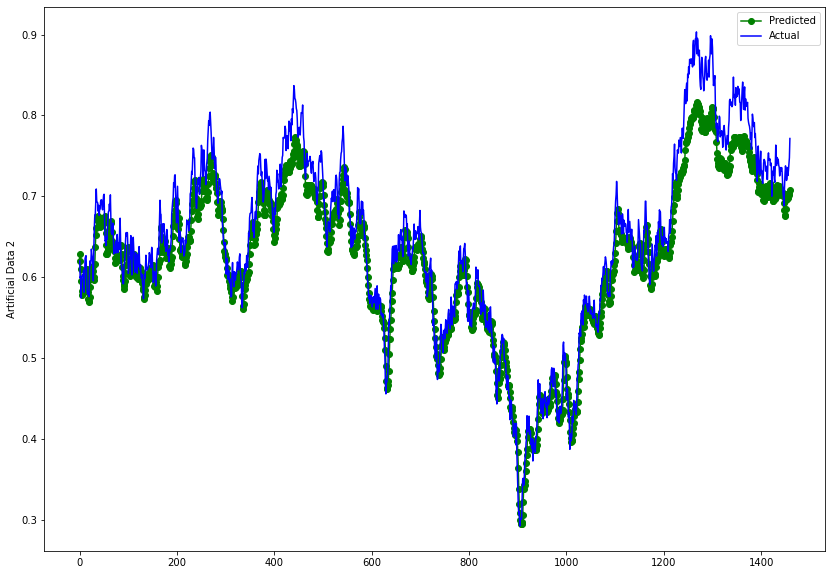

In [69]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artificial Data 2')
plt.legend()

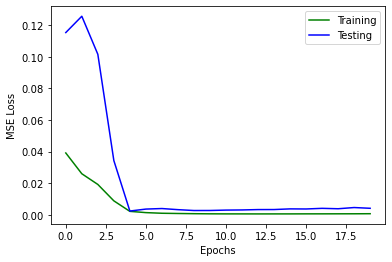

In [70]:
plt.plot(art2_train_mse, color="g", label="Training")
plt.plot(art2_test_mse, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

### (2) Running with L1 Loss

In [71]:
lr = 0.001
rnn_art2_2, art2_train_l1, art2_test_l1, predictions, values = train(train_loader, test_loader, lr, model_type="RNN", loss_func = "l1")

/Users/annesherry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of RNN model
Epoch 1/20 Done, Total Training Loss: 0.24811540570642268
Total Testing MSELoss: 0.6041667461395264
Total Time Elapsed: 0.7205450109999987 seconds

Epoch 2/20 Done, Total Training Loss: 0.1820606073712582
Total Testing MSELoss: 0.5274592041969299
Total Time Elapsed: 0.7178596999999911 seconds

Epoch 3/20 Done, Total Training Loss: 0.1677986387531836
Total Testing MSELoss: 0.49065637588500977
Total Time Elapsed: 0.7190128729999969 seconds

Epoch 4/20 Done, Total Training Loss: 0.14402899772420033
Total Testing MSELoss: 0.4127771556377411
Total Time Elapsed: 0.7019502849999952 seconds

Epoch 5/20 Done, Total Training Loss: 0.12378146905697636
Total Testing MSELoss: 0.4215273857116699
Total Time Elapsed: 0.7012011850000022 seconds

Epoch 6/20 Done, Total Training Loss: 0.11361167276953603
Total Testing MSELoss: 0.27891674637794495
Total Time Elapsed: 0.7018780040000081 seconds

Epoch 7/20 Done, Total Training Loss: 0.05748952022538735
Total Testing MSELoss: 

In [72]:
loss_df['art2_train_l1'] = art2_train_l1
loss_df['art2_test_l1'] = art2_test_l1
loss_df

,micro_train_mse,micro_test_mse,micro_train_l1,micro_test_l1,art1_train_mse,art1_test_mse,art1_train_l1,art1_test_l1,oil_train_mse,oil_test_mse,...,coin_train_l1,coin_test_l1,sp_train_mse,sp_test_mse,sp_train_l1,sp_test_l1,art2_train_mse,art2_test_mse,art2_train_l1,art2_test_l1
0,0.003124,0.126351,0.040713,0.369033,0.058538,0.009267,0.209034,0.130087,0.053410,0.293608,...,0.028614,0.398410,0.000668,0.767966,0.008589,0.868519,0.039126,0.115418,0.248115,0.604167
1,0.052854,0.349420,0.264020,0.694724,0.033161,0.002187,0.165147,0.086013,0.037524,0.137034,...,0.060016,0.419328,0.000500,0.696333,0.012697,0.859303,0.025966,0.125755,0.182061,0.527459
2,0.023845,0.211849,0.078269,0.308641,0.025474,0.003805,0.135224,0.136425,0.046503,0.154349,...,0.053418,0.400053,0.000464,0.719653,0.011424,0.828729,0.019189,0.101643,0.167799,0.490656
3,0.024101,0.185477,0.165820,0.345700,0.018345,0.004885,0.128466,0.087222,0.040057,0.107136,...,0.049555,0.385690,0.000550,0.664326,0.012630,0.835964,0.008794,0.034299,0.144029,0.412777
4,0.024140,0.190847,0.182292,0.459700,0.010832,0.008263,0.108416,0.101163,0.047790,0.056345,...,0.050579,0.380090,0.000458,0.705767,0.014248,0.824073,0.002134,0.002343,0.123781,0.421527
5,0.016442,0.124606,0.144756,0.414071,0.005274,0.000108,0.103799,0.113228,0.043956,0.068293,...,0.063662,0.396773,0.000573,0.699993,0.015668,0.793923,0.001339,0.003580,0.113612,0.278917
6,0.010992,0.055117,0.134957,0.386704,0.002213,0.000003,0.077675,0.055124,0.037031,0.059902,...,0.062084,0.388389,0.000478,0.639693,0.024841,0.822395,0.000933,0.003923,0.057490,0.128239
7,0.005984,0.013843,0.109368,0.250617,0.001438,0.000055,0.050978,0.049326,0.035185,0.035853,...,0.043945,0.357374,0.000467,0.708428,0.023162,0.819472,0.000785,0.003215,0.038983,0.100311
8,0.000733,0.013145,0.109945,0.202684,0.000908,0.000204,0.037049,0.038030,0.034035,0.039759,...,0.060772,0.369623,0.000422,0.684846,0.016713,0.815263,0.000659,0.002668,0.030152,0.080510
9,0.000339,0.008555,0.075010,0.162090,0.000595,0.000369,0.027755,0.038949,0.028856,0.039875,...,0.035518,0.277824,0.000455,0.662596,0.016627,0.827631,0.000576,0.002691,0.030173,0.066360


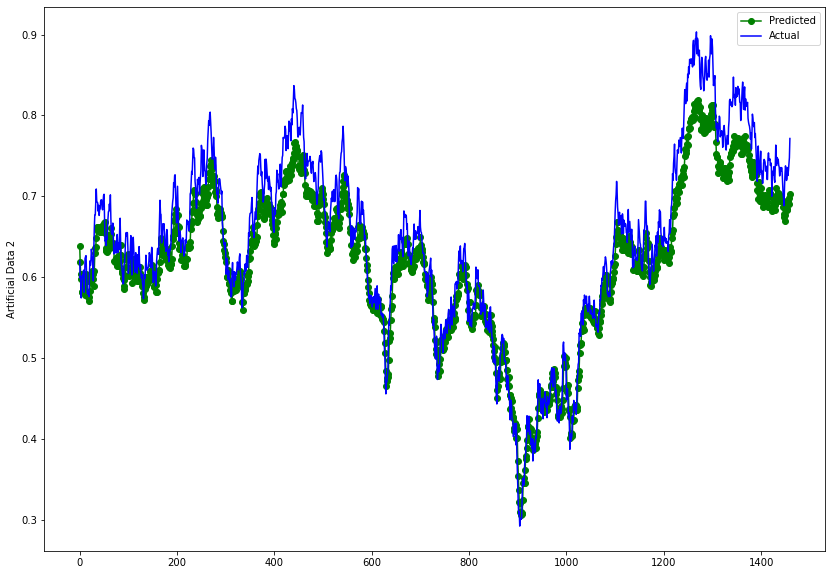

In [73]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artificial Data 2')
plt.legend()

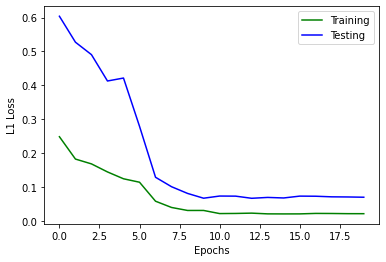

In [74]:
plt.plot(art2_train_l1, color="g", label="Training")
plt.plot(art2_test_l1, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()

## 